In [ ]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode('k-seq')
dev_mode.on()

from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Convergence test

The code to conduct convergence test see `clt/estimate-least-squares-convergence-test.py`

In [2]:
def get_test_res(with_1250=True, return_all=False):
    from k_seq.utility import file_tools
    
    folder = f"/mnt/storage/projects/k-seq/working/convergence_test/{'with_1250' if with_1250 else 'no_1250'}/"
    seq_params = file_tools.read_pickle(f'{folder}/seq_param.pkl')
    conv_res = file_tools.read_pickle(f'{folder}/convergence_res.pkl')
    seq_params['A_std'] = [res.A.std() for seq, res in conv_res.items()]
    seq_params['A_range'] = [res.A.max() - res.A.min() for seq, res in conv_res.items()]
    if return_all:
        reacted_frac = file_tools.read_pickle(f'{folder}/reacted_frac.pkl')
        c = file_tools.read_pickle(f'{folder}/c.pkl')
        return seq_params, conv_res, reacted_frac, c
    else:
        return seq_params

In [3]:
conv_res = get_test_res()
conv_res_no_1250 = get_test_res(with_1250=False)

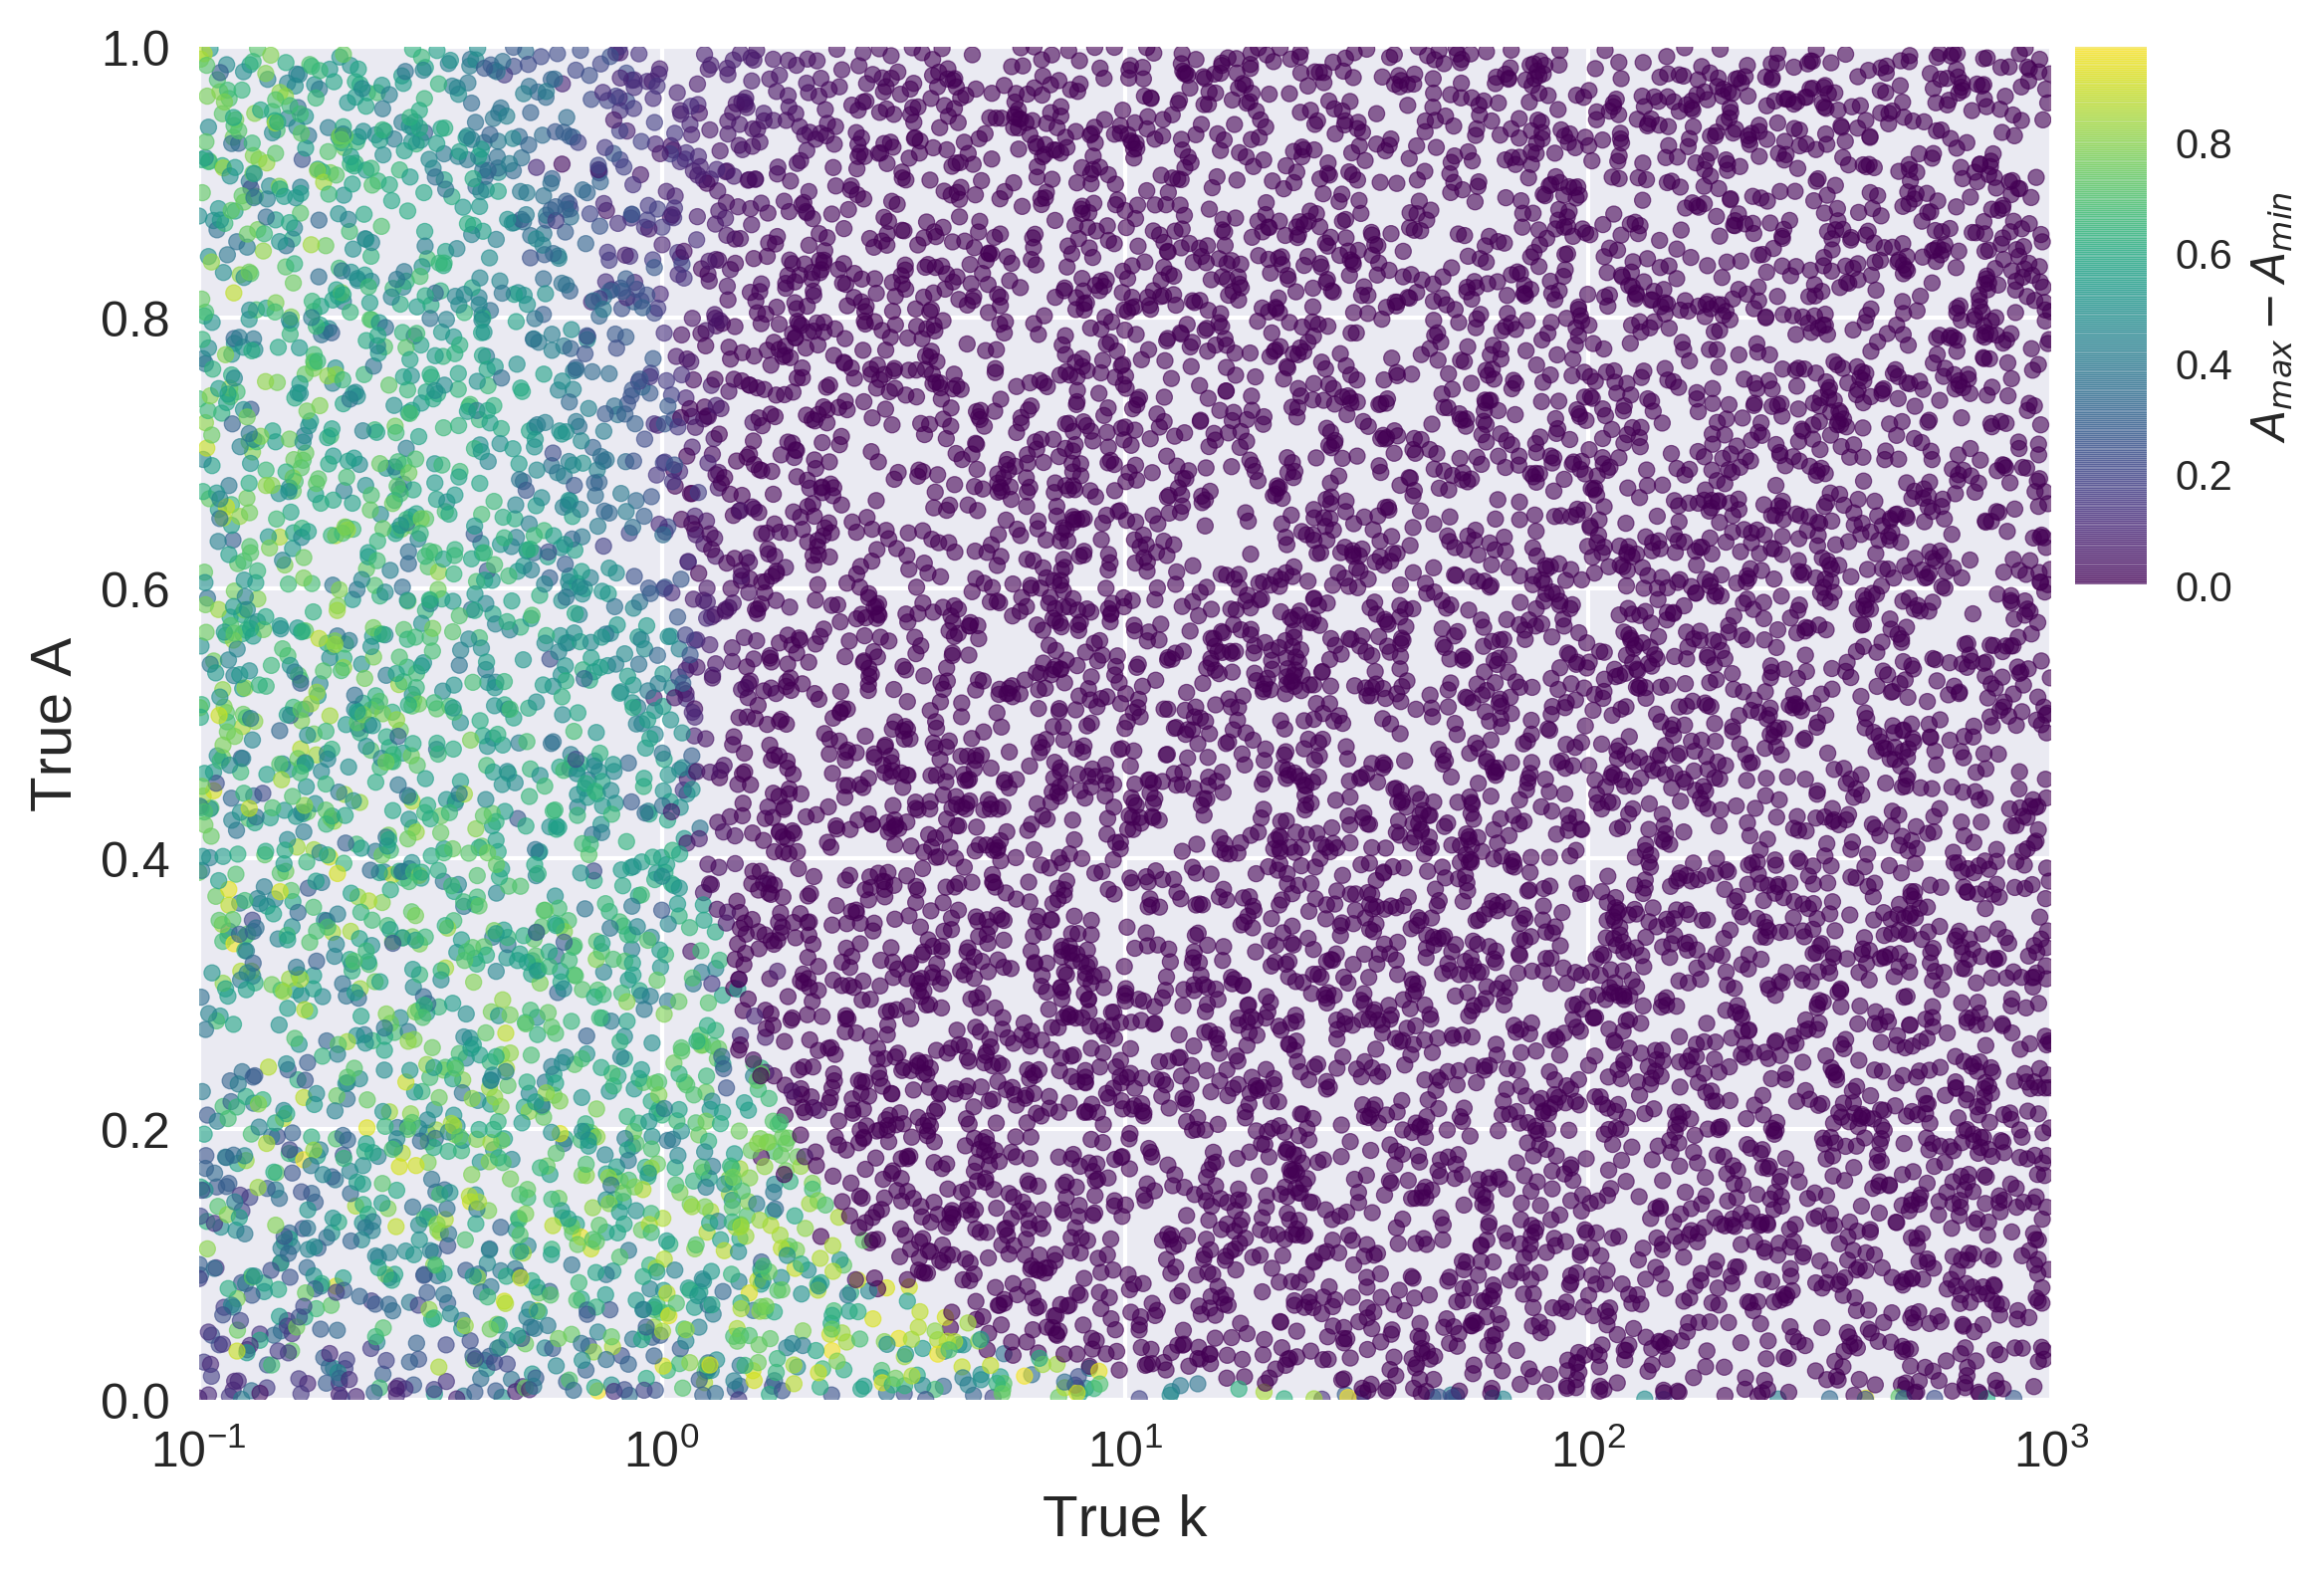

In [66]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])

im = ax.scatter(x=conv_res.k, y=conv_res.A, c=conv_res.A_range,
                cmap='viridis', s=15, alpha=0.6)
ax.set_xscale('log')
ax.set_xlim([0.1, 1e3])
ax.set_ylim([0, 1])
ax.tick_params(labelsize=12)
ax.set_xlabel('True k', fontsize=14)
ax.set_ylabel('True A', fontsize=14)

cax = fig.add_axes([0.91, 0.58, 0.03, 0.3])
fig.colorbar(im, cax=cax, orientation='vertical')
cax.set_ylabel('$A_{max} - A_{min}$')

plt.show()

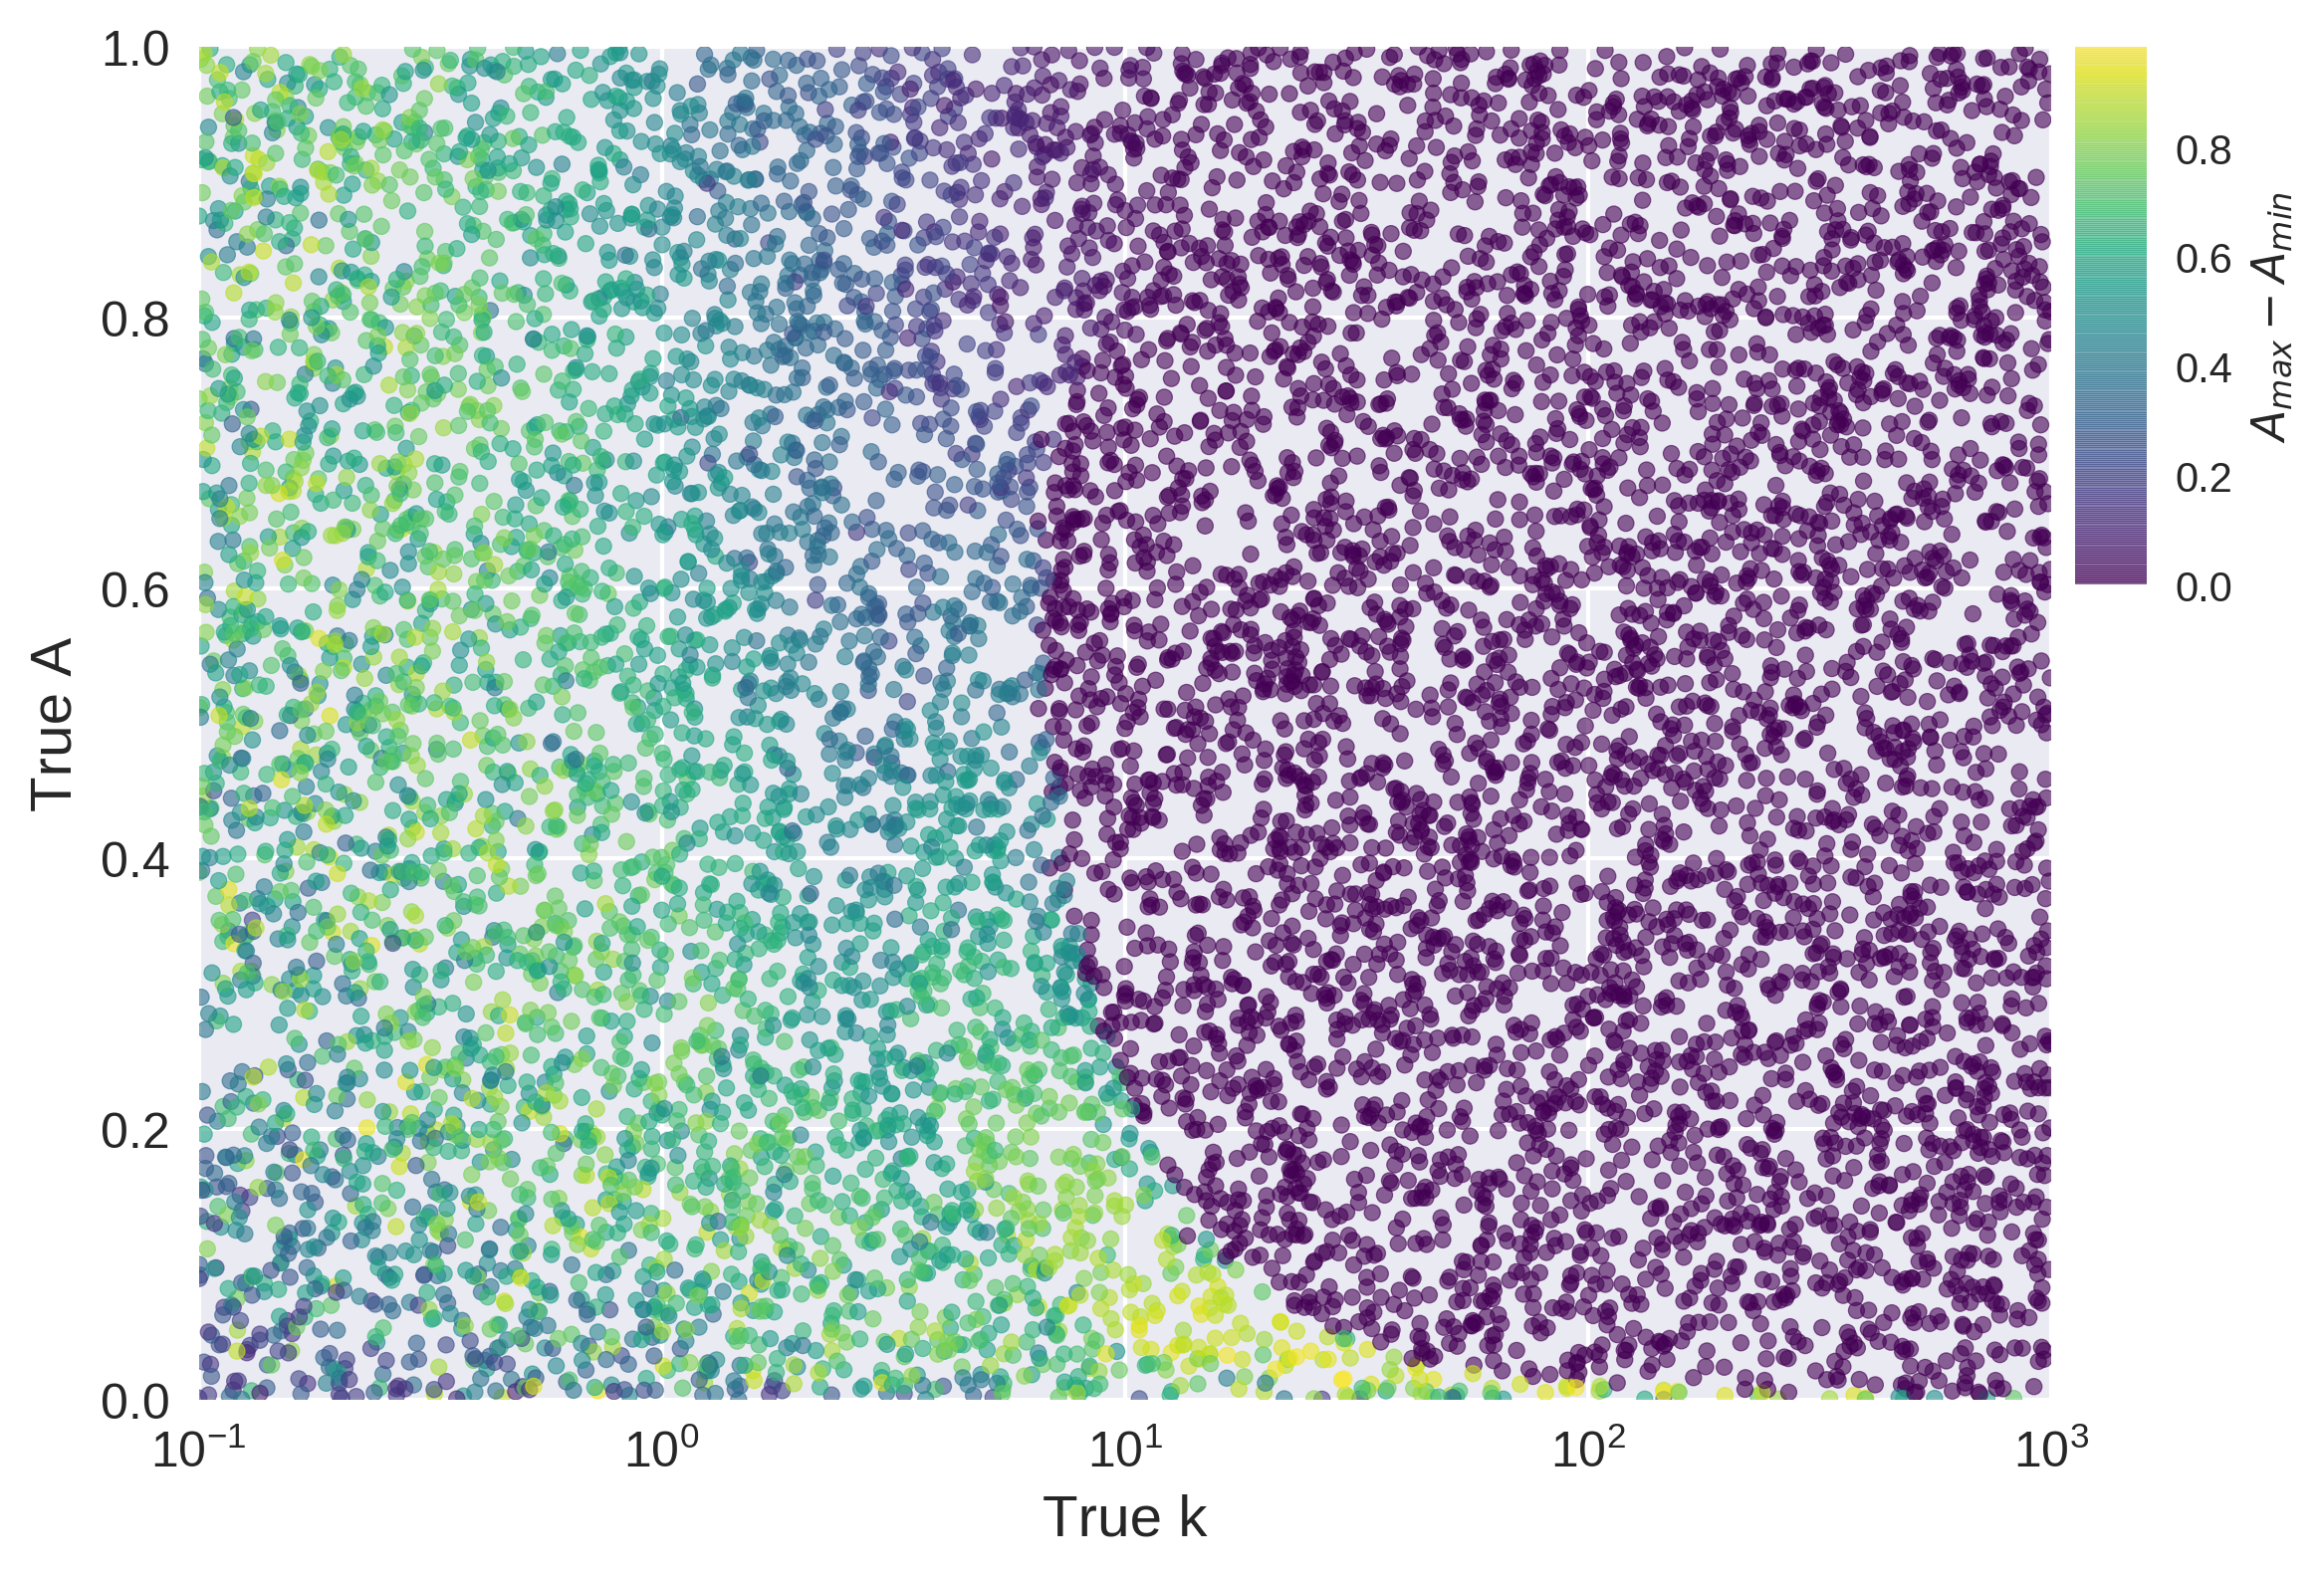

In [67]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])

im = ax.scatter(x=conv_res_no_1250.k, y=conv_res_no_1250.A, c=conv_res_no_1250.A_range,
                cmap='viridis', s=15, alpha=0.6)
ax.set_xscale('log')
ax.set_xlim([0.1, 1e3])
ax.set_ylim([0, 1])
ax.tick_params(labelsize=12)
ax.set_xlabel('True k', fontsize=14)
ax.set_ylabel('True A', fontsize=14)

cax = fig.add_axes([0.91, 0.58, 0.03, 0.3])
fig.colorbar(im, cax=cax, orientation='vertical')
cax.set_ylabel('$A_{max} - A_{min}$')

plt.show()

### Sample figures for convergence test

In [149]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_curve(model, x, y, param, major_param=None, subsample=20,
               x_label=None, y_label=None, x_lim=None, y_lim=None, ax=None):
    """Plot curve of fitting results
    Args:
        model (callable): kinetic model returns y with first argument as x
        x (list-like): x values of data
        y (list-like): y values of corresponding x data, same length
        param (dict or pd.DataFrame): estimated parameters for model from fitting(s)
        major_param (dict): a major parameter estimated
        subsample (int): maximal num of fitting curves to show
        ax (plt.Axes): Axes to plot on
    """
    import pandas as pd
    import numpy as np
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    
    plot_args = {'color': '#AEAEAE', 'alpha': 0.3} if major_param \
    else {'color': "#2C73B4", 'alpha': 0.3}
    
    # plot curves
    if x_lim:
        xs = np.linspace(0, x_lim[1] * 0.9, 100)
    else:
        xs = np.linspace(0, np.max(x) * 1.1, 100)
    
    def add_curve(data):
        if isinstance(data, dict):
            y_ = model(xs, **data)
        elif isinstance(data, pd.Series):
            y_ = model(xs, **data.to_dict())
        else:
            raise TypeError('Unknown paramter input type')
        ax.plot(xs, y_, marker=None, **plot_args)
        
    if isinstance(param, dict):
        add_curve(param)
    elif isinstance(param, pd.DataFrame):
        if param.shape[0] > subsample:
            param = param.sample(subsample)
        param.apply(add_curve, axis=1)
    
    # add major curve if applicable
    if major_param:
        plot_args = {'color': "#2C73B4", 'alpha': 0.8}
        add_curve(major_param)
    
    # add raw data points
    ax.scatter(x, y, marker='x', s=50, color='#F39730', zorder=3)
        
    if x_lim:
        ax.set_xlim(x_lim)
    if y_lim:
        ax.set_ylim(y_lim)
    if x_label:
        ax.set_xlabel(x_label, fontsize=14)
    if y_label:
        ax.set_ylabel(y_label, fontsize=14)

def mse(y_, y):
    """Unweighted mean square error"""
    return np.mean((y_ - y)**2)
        
def plot_cost_heatmap(model, x, y, param, param_name, scan_range,
                      fixed_params=None,
                      param_log=False, resolution=101,
                      cost_fn=None, ax=None):
    """Plot a heatmap to show the energy landscap for cost function, on two params
    
    Args:
      model (callable): kinetic model with first argument as x. Broadcase should be 
        implemented with x as the innest dimension
      x (list-like): x values of data
      y (list-like): y values of corresponding x data, same length
      param (dict or pd.DataFrame): estimated parameters for model from fitting(s)
      param_name (2-tuple of str): name for two params to scan
      scan_range (dict of two tuple): scan range of two parameters:
        {param1:(low, high),
         param2:(low, high)}
        Note: in model output, dim of param1 should always be out of dim param2
      fix_params (dict): optional. If there is any fixed params, except for the two to scan
      param_log (bool or dict of bool): if the scan is spacing on log scale
      resolution (int or dict of int): resolution for two scan, default 50
      cost_fn (callable): cost function in calculating cost between y_ and y, take (y_, y)
      ax (plt.Axes): Axes to plot on
    """
    from functools import partial
    
    
    if isinstance(resolution, int):
        resolution = {param_name[0]: resolution, param_name[1]: resolution}
    if isinstance(param_log, bool):
        param_log = {param_name[0]: param_log, param_name[1]: param_log}
    
    def get_scan_point(scan_range, resolution=101, log=False):
        """Generate np.ndarray contains the scanning point"""
        if log:
            return np.logspace(np.log10(scan_range[0]), np.log10(scan_range[1]), resolution)
        else:
            return np.linspace(scan_range[0], scan_range[1], resolution)
    
    param_to_scan = {param: get_scan_point(scan_range[param], resolution[param], param_log[param])
                     for param in param_name}
   
    if not fixed_params:
        fixed_params = {}
    
    # generate ys_ with shape (param1, param2)
    ys_ = model(x, **param_to_scan, **fixed_params)
    cost = np.apply_along_axis(arr=ys_, axis=-1, func1d=partial(cost_fn, y=np.array(y)))
    
    # plot heatmap
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.grid(False)
    
    hm = ax.imshow(np.log10(cost), vmax=np.max(np.log10(cost)), cmap='viridis', origin='lower')
    ax.set_xlabel(param_name[1], fontsize=14)
    ax.set_ylabel(param_name[0], fontsize=14)
    
    # plot marker
    
    def value_to_loc(value, param_to_scan, log):
        """Convert value for parameter to its location on resolution scale"""

        vmin = param_to_scan[0]
        vmax = param_to_scan[-1]
        
        if log:
            return np.log10(value / vmin) / np.log10(vmax / vmin) * len(param_to_scan)
        else:
            return (value - vmin) / (vmax - vmin) * len(param_to_scan)
    
    ax.scatter(value_to_loc(param[param_name[1]], param_to_scan[param_name[1]], param_log[param_name[1]]),
        value_to_loc(param[param_name[0]], param_to_scan[param_name[0]], param_log[param_name[0]]),
        marker='x', alpha=0.8, color='#F39730', label='Estimated value'
    )
    
    # add ticks
    p = param_name[1]
    tick_ix = np.linspace(0, resolution[p] - 1, 5, dtype=int)
    ax.set_xticks(tick_ix)
    
    if param_log[p]:
        ax.set_xticklabels([f'{tick:.1e}' for tick in param_to_scan[p][tick_ix]])
    else:
        ax.set_xticklabels([f'{tick:.2f}' for tick in param_to_scan[p][tick_ix]])
    p = param_name[0]
    tick_ix = np.linspace(0, resolution[p] - 1, 5, dtype=int)
    ax.set_yticks(tick_ix)
    if param_log[p]:
        ax.set_yticklabels([f'{tick:.1e}' for tick in param_to_scan[p][tick_ix]])
    else:
        ax.set_yticklabels([f'{tick:.2f}' for tick in param_to_scan[p][tick_ix]])
        
    ax.set_xlim([-0.5, resolution[param_name[1]] - 0.5])
    ax.set_ylim([-0.5, resolution[param_name[0]] - 0.5])

    fig = plt.gcf()
    cbar = fig.colorbar(hm, fraction=0.045, pad=0.05)
    cbar.set_label(r'$\log10(MSE)$', fontsize=16)
    cbar.ax.tick_params(labelsize=12)

In [5]:
from k_seq.model import kinetic
reload(kinetic)
BYOModel = kinetic.BYOModel

In [6]:
seq_res, conv_res, reacted_frac, c = get_test_res(with_1250=True, return_all=True)

In [7]:
converged_ix = 5041
unconverged_ix = 1902

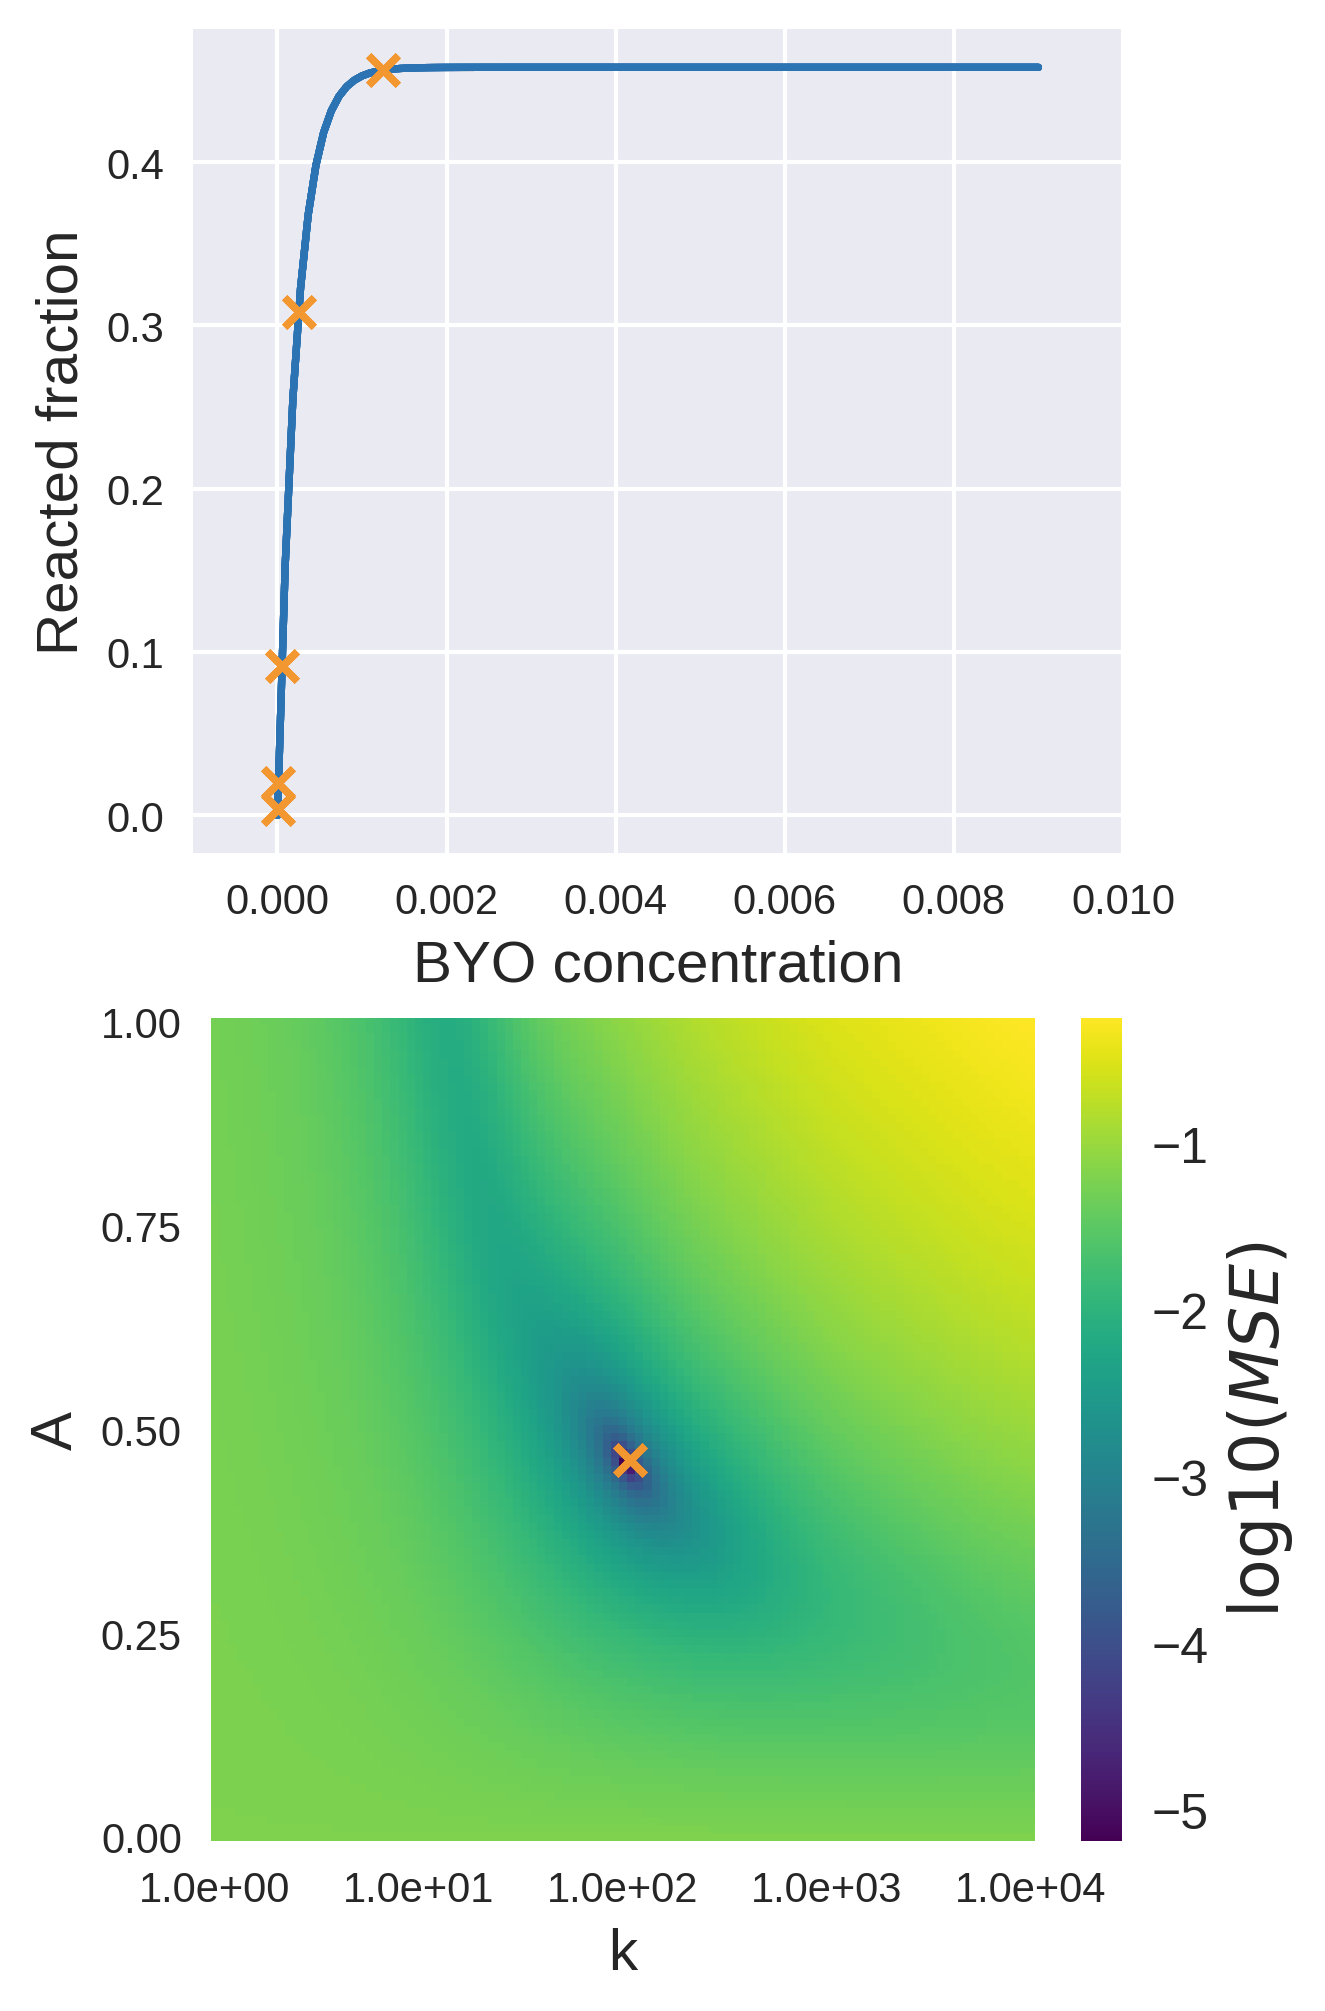

In [148]:
ix = converged_ix
fig, axes = plt.subplots(2, 1, figsize=(4, 8))

plot_curve(model=BYOModel.reacted_frac, x=np.array(c), y=np.array(reacted_frac.loc[ix]), 
           param=conv_res[ix][['k', 'A']], major_param=None,
           x_label='BYO concentration', y_label='Reacted fraction',
           x_lim=(-0.001, 0.01), y_lim=None, ax=axes[0])

ys_ = plot_cost_heatmap(model=BYOModel.reacted_frac,
                        x=np.array(c), y=np.array(reacted_frac.loc[ix]),
                        param=conv_res[ix][['k', 'A']],
                        param_name = ('A', 'k'),
                        scan_range={'A': (0, 1), 'k':(1, 10000)},
                        param_log={'A': False, 'k':True}, resolution=101,
                        cost_fn=mse, ax=axes[1])

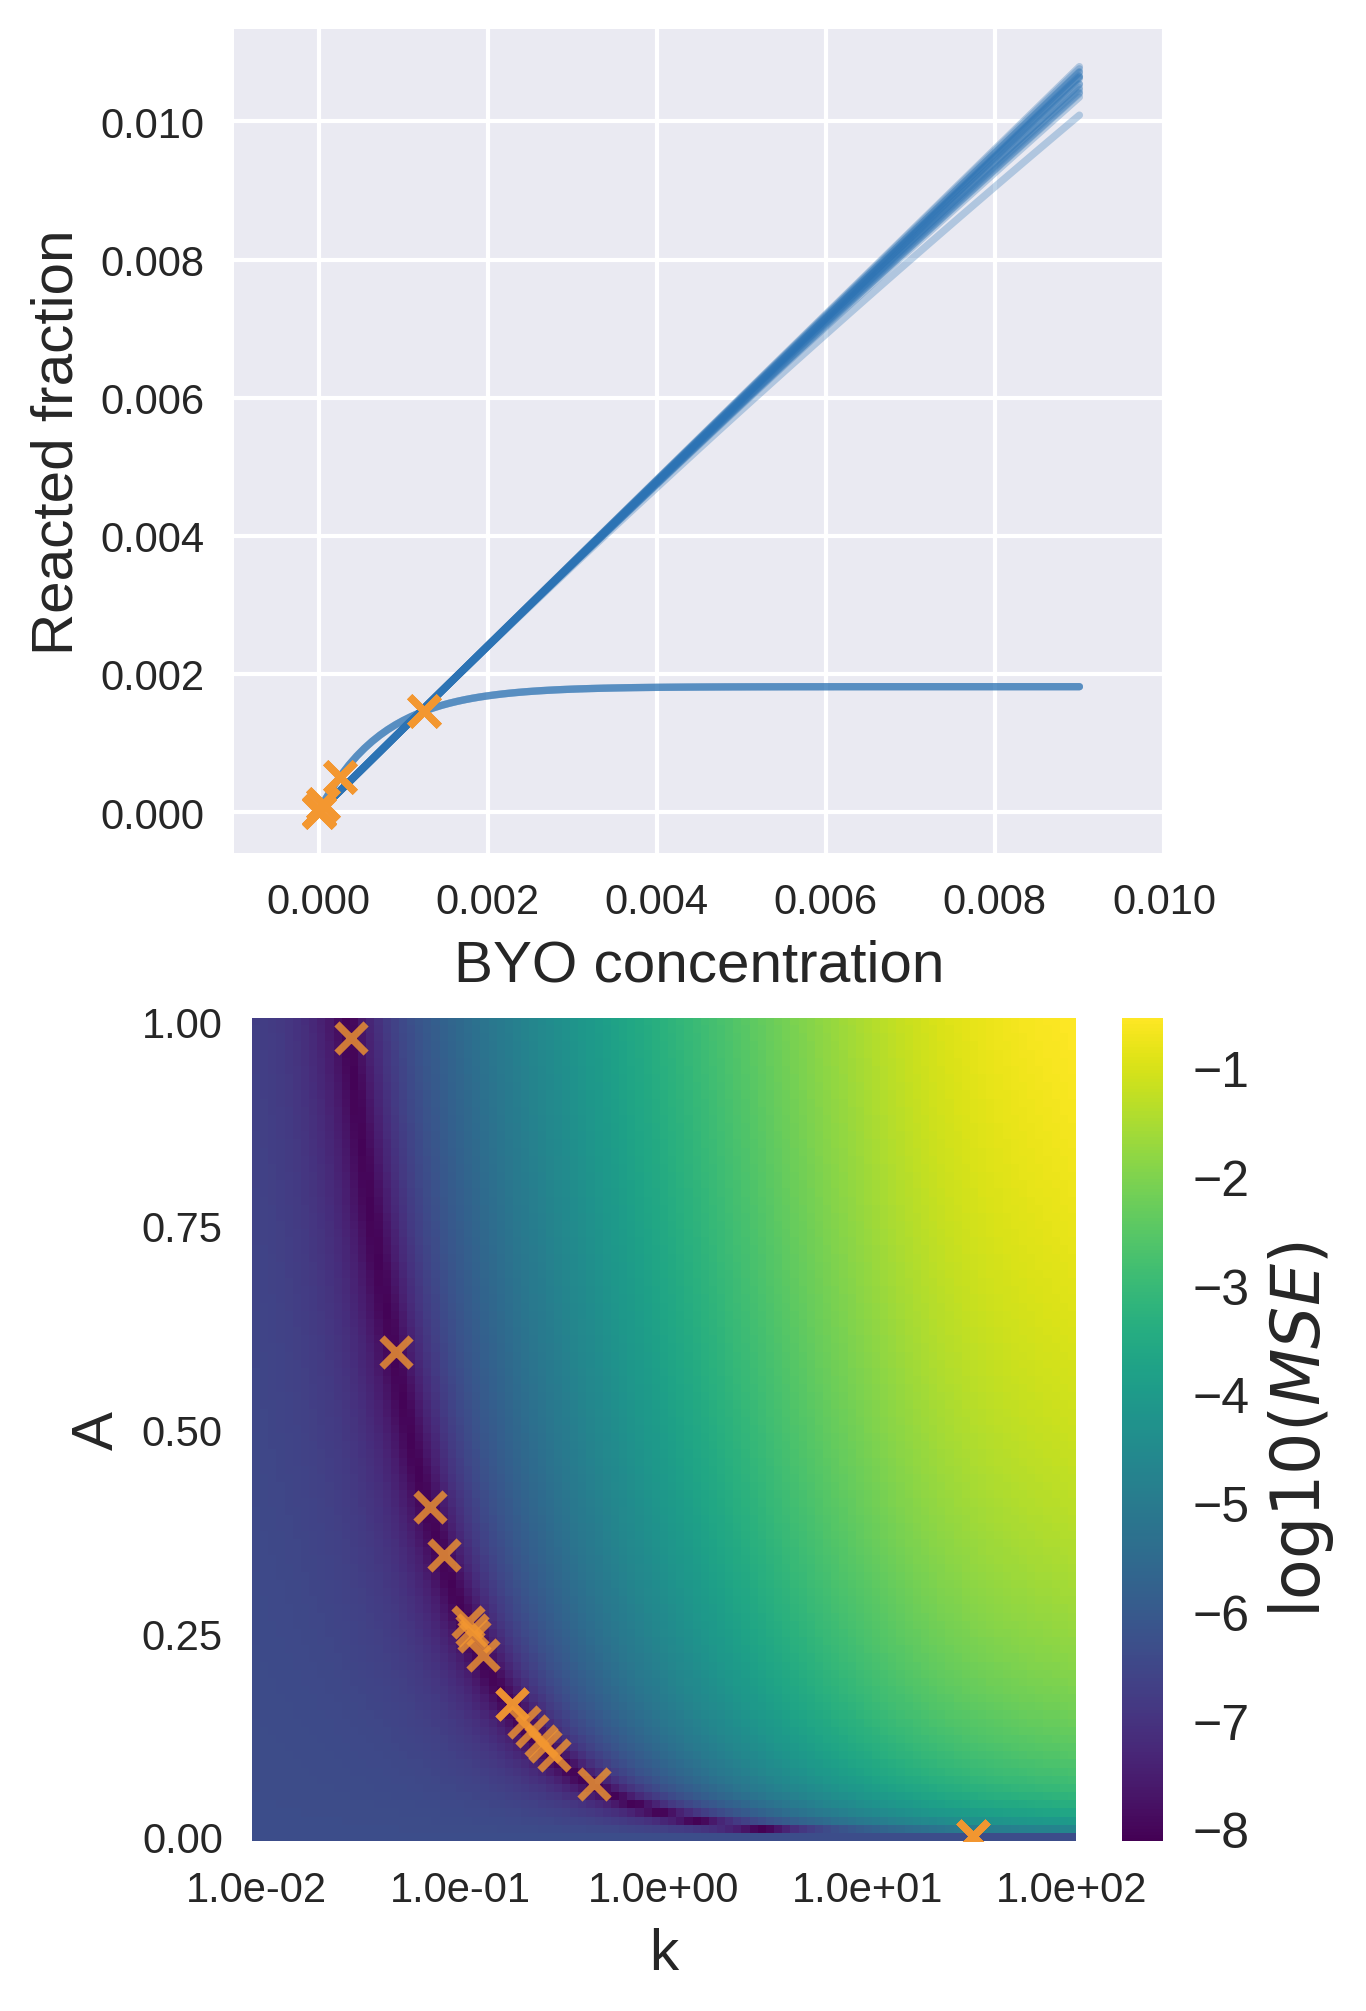

In [146]:
ix = unconverged_ix

fig, axes = plt.subplots(2, 1, figsize=(4, 8))

plot_curve(model=BYOModel.reacted_frac, x=np.array(c), y=np.array(reacted_frac.loc[ix]), 
           param=conv_res[ix][['k', 'A']], major_param=None,
           x_label='BYO concentration', y_label='Reacted fraction',
           x_lim=(-0.001, 0.01), y_lim=None, ax=axes[0])

ys_ = plot_cost_heatmap(model=BYOModel.reacted_frac,
                        x=np.array(c), y=np.array(reacted_frac.loc[ix]),
                        param=conv_res[ix][['k', 'A']],
                        param_name = ('A', 'k'),
                        scan_range={'A': (0, 1), 'k':(0.01, 100)},
                        param_log={'A': False, 'k':True}, resolution=101,
                        cost_fn=mse, ax=axes[1])